### Plot and compare Eulerian and Lagrangian binned average covariance of the demodulated velocity signal

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
#import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

#from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
#import mitequinox.sigp as sp



In [2]:
#Load data
path = '/Users/zcaspar/codes/mit4320/'
dsL = xr.open_dataset(path+'binned_Lcov_dl2.nc') # Lagrangian SSU, 2° bins
dsE = xr.open_dataset(path+'binned_Ecov_dl2.nc') # Eulerian SSU, 2° bins
dsE_low = xr.open_dataset(path+'binned_Ecov_low_dl2.nc') # Eulerian SSU, bf, 2° bins

dsL_dl1 = xr.open_dataset(path+'binned_Lcov_dl1.nc') # Lagrangian SSU, 1° bins
dsE_dl1 = xr.open_dataset(path+'binned_Ecov_dl1.nc') # Eulerian SSU, 1° bins

dsL_vv = xr.open_dataset(path+'binned_Lcov_vv.nc') # Lagrangian SSV, 2° bins

#SSUV spectra
E_SSUV = xr.open_dataset(path+'/E_SSUV.nc') #Eulerian
L_SSUV = xr.open_dataset(path+'/L_SSUV.nc') #Lagrangian

In [3]:
#Mean field
dsL_stats = xr.open_zarr(path+'L_dl1.0_stats.zarr')

In [4]:
# Subsampling Lagrangian data to  match Eulerian dataset
dsL = dsL.isel(lags=slice(0,None,3)).sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))

In [5]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator

In [6]:
dsE = dsE.where(dsE.rr!=0) # change 0 to nan (corresponding to land)
dsE_low = dsE_low.where(dsE_low.rr!=0) # change 0 to nan (corresponding to land)
dsE_dl1 = dsE_dl1.where(dsE_dl1.rr!=0)

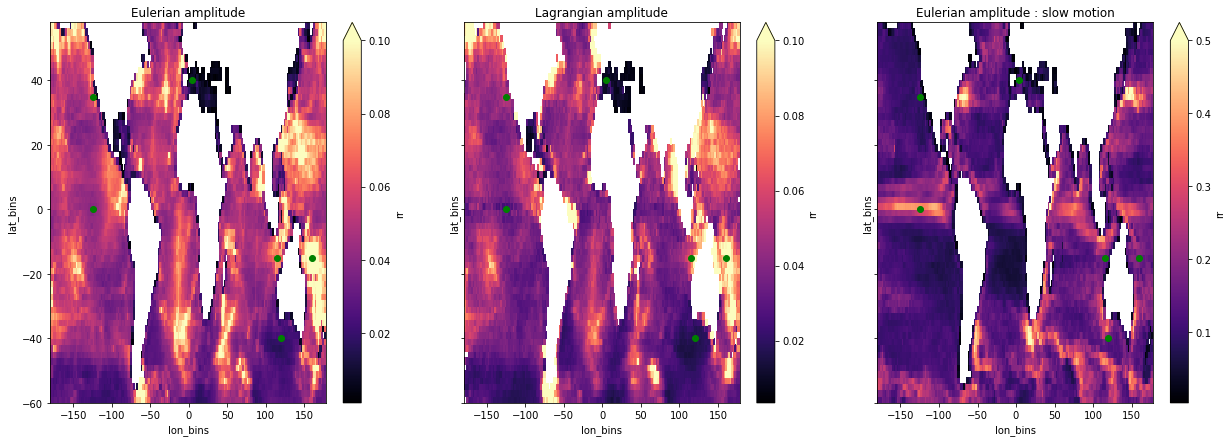

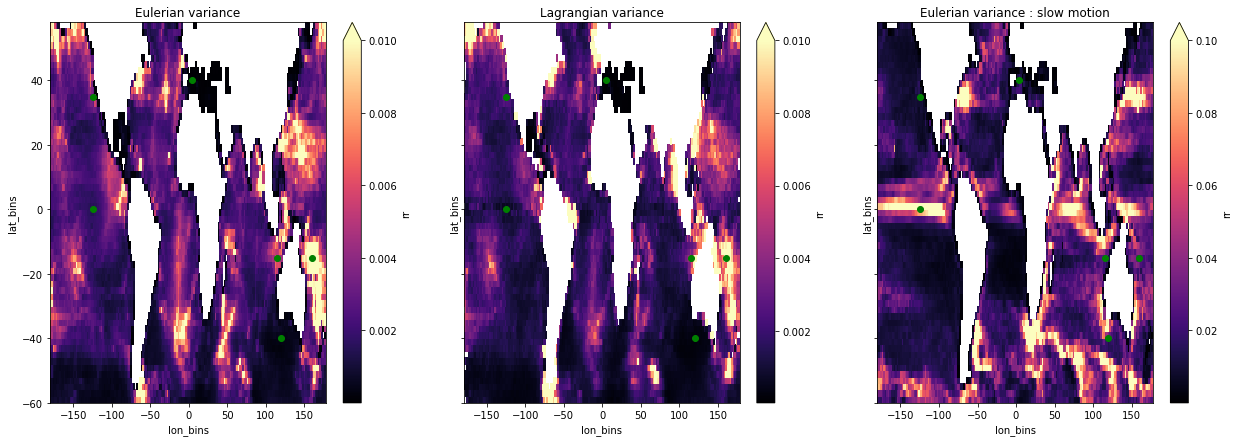

In [7]:
%matplotlib inline
cmap = 'magma'
fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
np.sqrt(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.1,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian amplitude')
np.sqrt(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.1,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian amplitude')
np.sqrt(dsE_low['rr'].isel(lags=0)).plot(y='lat_bins',cmap=cmap,vmax=0.5,ax=axs[2])
#np.sqrt(dsL_stats['EKE_ibinned']).sel(lat=slice(-60,60)).plot(y='lat',vmax=0.5,ax=axs[2],cmap=cmap)
axs[2].set_title('Eulerian amplitude : slow motion')
for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]:
    axs[0].scatter(bbox[0],bbox[1],c='g')
    axs[1].scatter(bbox[0],bbox[1],c='g')
    axs[2].scatter(bbox[0],bbox[1],c='g')
#plt.show()

fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian variance')
(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian variance')
(dsE_low['rr'].isel(lags=0)).plot(y='lat_bins',cmap=cmap,vmax=0.1,ax=axs[2])
#np.sqrt(dsL_stats['EKE_ibinned']).sel(lat=slice(-60,60)).plot(y='lat',vmax=0.5,ax=axs[2],cmap=cmap)
axs[2].set_title('Eulerian variance : slow motion')
#dsL_stats['EKE_ibinned'].sel(lat=slice(-60,60)).plot(y='lat',vmax=0.2,ax=axs[2],cmap=cmap)
#axs[2].set_title('Interpolated Eulerian EKE')
for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]:
    axs[0].scatter(bbox[0],bbox[1],c='g')
    axs[1].scatter(bbox[0],bbox[1],c='g')
    axs[2].scatter(bbox[0],bbox[1],c='g')
#plt.show()

#### Comments : 
Green points correpond to area of interest defined in previous cell.

Largest discrepancies seem to be near coastal area (even after removing area where depth is smaller than 500m)

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


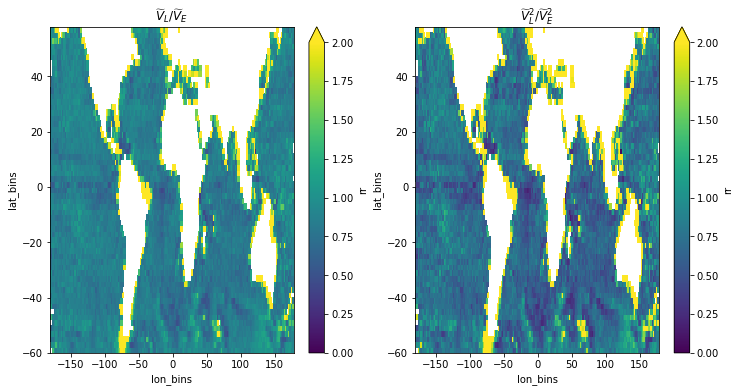

In [8]:
cmap='viridis'
fig,axs = plt.subplots(1,2,figsize=(12,6))
(np.sqrt(dsL.isel(lags=0).rr)/np.sqrt(dsE.isel(lags=0).rr)).plot(cmap=cmap,vmax=2,vmin=0,y='lat_bins',ax=axs[0])
axs[0].set_title(r'$\widetilde{V}_L/\widetilde{V}_E$')
((dsL.isel(lags=0).rr)/(dsE.isel(lags=0).rr)).plot(cmap=cmap,vmax=2,y='lat_bins',vmin=0,ax=axs[1])
axs[1].set_title(r'$\widetilde{V}_L^2/\widetilde{V}_E^2$');

Comments:

1) Lagrangian larger in "coastal" area and in some parts of the Southern ocean

2) Eulerian larger in some other parts of the Southern ocean and near the equator

In [9]:
ratio = dsL.isel(lags=0).rr/dsE.isel(lags=0).rr
ratio_dl1 = dsL_dl1.isel(lags=0).rr/dsE_dl1.isel(lags=0).rr

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/plot/plot.py:959: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  primitive = ax.pcolormesh(x, y, z, **kwargs)


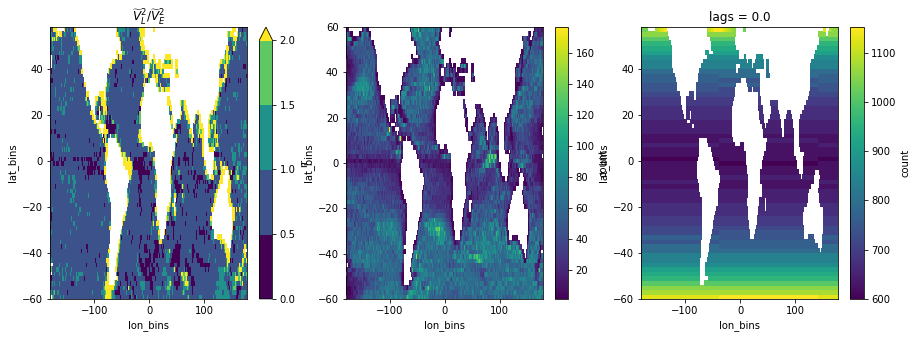

In [10]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ratio.plot(vmax=2,levels=[0,0.5,1,1.5,2],ax=axs[0])
axs[0].set_title(r'$\widetilde{V}_L^2/\widetilde{V}_E^2$')
dsL['count'].where(dsL['count']>0).plot(ax=axs[1])
dsE['count'].where(dsE['count']>0).isel(lags=0).plot(ax=axs[2],y='lat_bins')

Comments : 

1) Fewer data points in the bins next to "land bins"

2) Fewer data points near the equator in the Atlantic and Pacific oceans

3) Weird area south Florida : Lagrangian variance larger and les than 20 datapoints ??

Bonus : Inhomogeneities in grid points, sharp near faces limits

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


Text(0.5, 1.0, 'Lagrangian variance : meridional velocity')

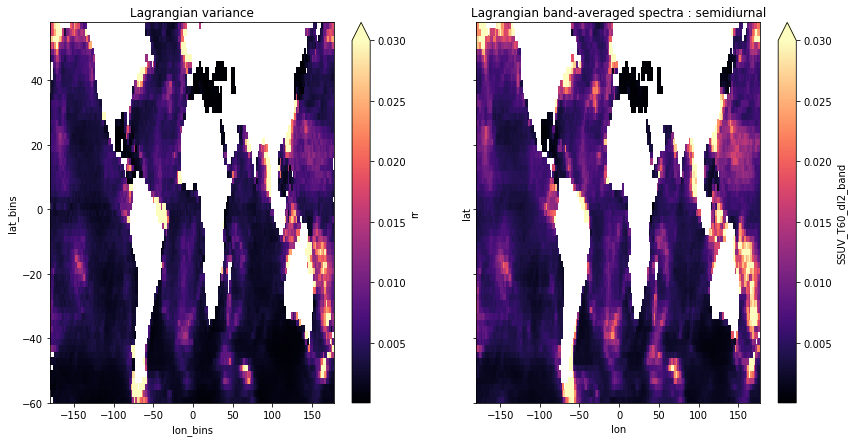

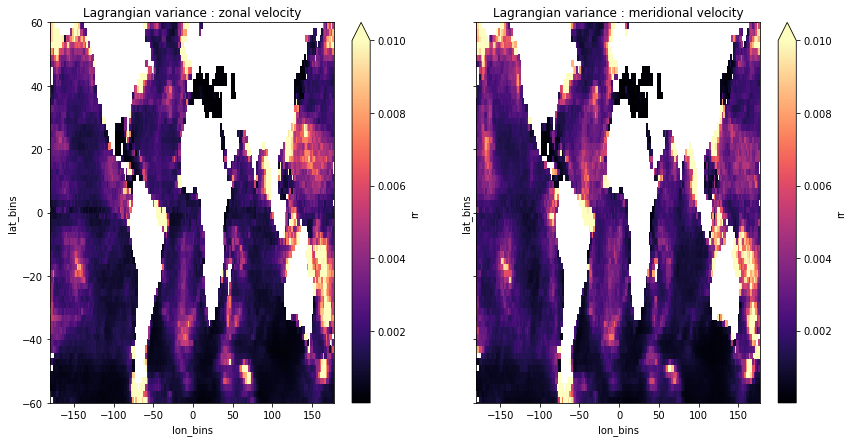

In [11]:
#Side work : variance from spectra vs from covariance

cmap='magma'
fig,axs = plt.subplots(1,2,figsize=(14,7),sharey=True)
#(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
#axs[0].set_title('Eulerian variance')
(dsL.isel(lags=0).rr+dsL_vv.isel(lags=0).rr).plot(ax=axs[0],vmax=0.03,cmap=cmap,y='lat_bins')
axs[0].set_title('Lagrangian variance')
(L_SSUV['SSUV_T60_dl2_band'].sel(frequency_band='semidiurnal_0dot4')).plot(y='lat',cmap=cmap,vmax=0.03,ax=axs[1])
#np.sqrt(dsL_stats['EKE_ibinned']).sel(lat=slice(-60,60)).plot(y='lat',vmax=0.5,ax=axs[2],cmap=cmap)
axs[1].set_title('Lagrangian band-averaged spectra : semidiurnal')
#dsL_stats['EKE_ibinned'].sel(lat=slice(-60,60)).plot(y='lat',vmax=0.2,ax=axs[2],cmap=cmap)
#axs[2].set_title('Interpolated Eulerian EKE')
#
#plt.show()
fig,axs = plt.subplots(1,2,figsize=(14,7),sharey=True)
(dsL.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
(dsL_vv.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins',ylim=(-60,60))
axs[0].set_title('Lagrangian variance : zonal velocity');
axs[1].set_title('Lagrangian variance : meridional velocity')

### Same plots for 1°bins

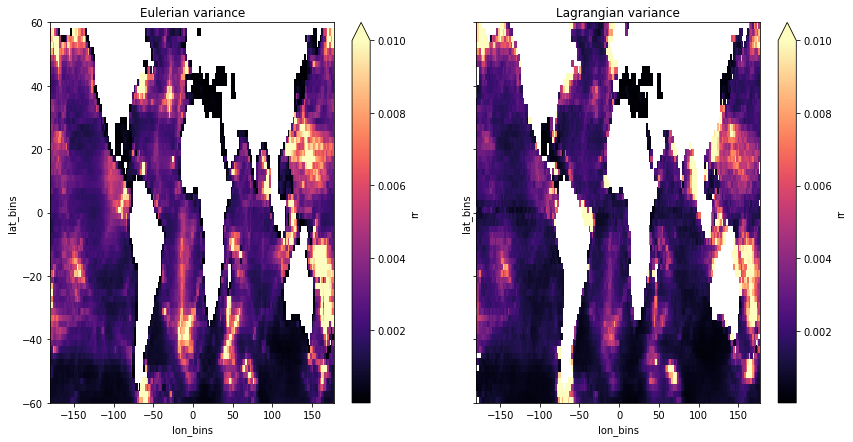

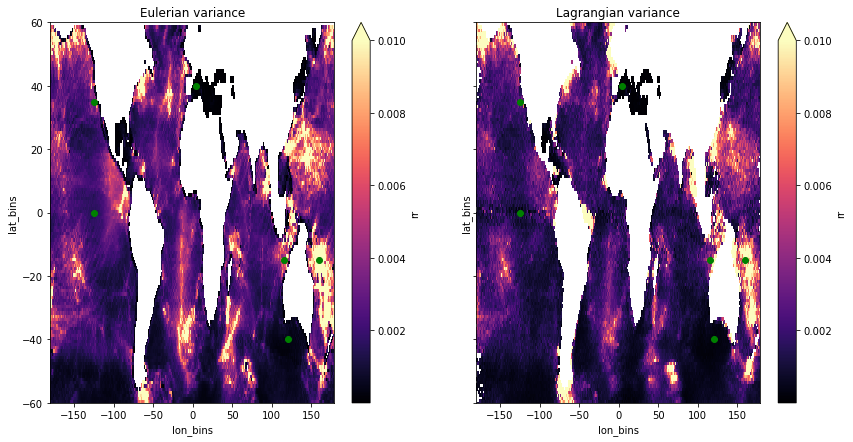

In [12]:
cmap = 'magma'
fig,axs = plt.subplots(1,2,figsize=(14,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins',ylim=(-60,60))
axs[0].set_title('Eulerian variance')
(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins',ylim=(-60,60))
axs[1].set_title('Lagrangian variance')

fig,axs = plt.subplots(1,2,figsize=(14,7),sharey=True)
(dsE_dl1.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins',ylim=(-60,60))
axs[0].set_title('Eulerian variance')
(dsL_dl1.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins',ylim=(-60,60))
axs[1].set_title('Lagrangian variance')
for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]:
    axs[0].scatter(bbox[0],bbox[1],c='g')
    axs[1].scatter(bbox[0],bbox[1],c='g')
#plt.show()

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/plot/plot.py:959: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  primitive = ax.pcolormesh(x, y, z, **kwargs)


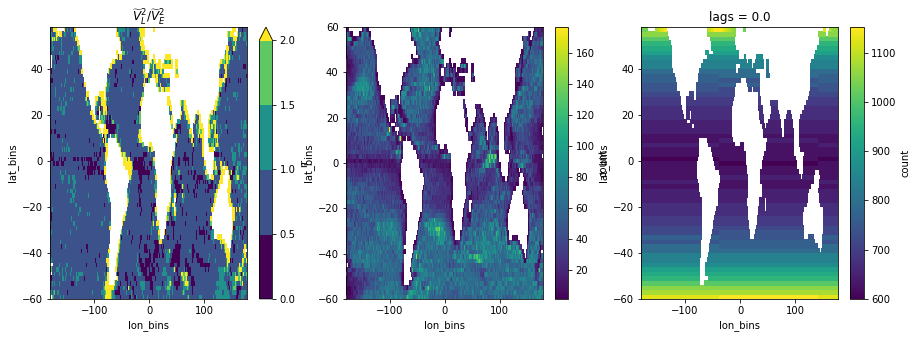

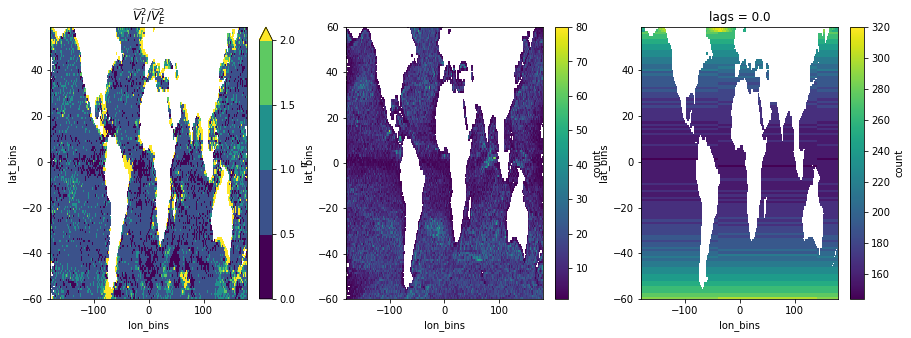

In [13]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ratio.plot(vmax=2,levels=[0,0.5,1,1.5,2],ax=axs[0])
axs[0].set_title(r'$\widetilde{V}_L^2/\widetilde{V}_E^2$')
dsL['count'].where(dsL['count']>0).plot(ax=axs[1])
dsE['count'].where(dsE['count']>0).isel(lags=0).plot(ax=axs[2],y='lat_bins')
fig,axs = plt.subplots(1,3,figsize=(15,5))
ratio_dl1.plot(vmax=2,levels=[0,0.5,1,1.5,2],ax=axs[0])
axs[0].set_title(r'$\widetilde{V}_L^2/\widetilde{V}_E^2$')
dsL_dl1['count'].where(dsL_dl1['count']>0).plot(ax=axs[1],ylim=(-60,60))
dsE_dl1['count'].where(dsE_dl1['count']>0).isel(lags=0).plot(ax=axs[2],y='lat_bins')

### Zonally averaged (2° bins for now)

Text(0.5, 1.0, 'Lagrangian real-imag covariance')

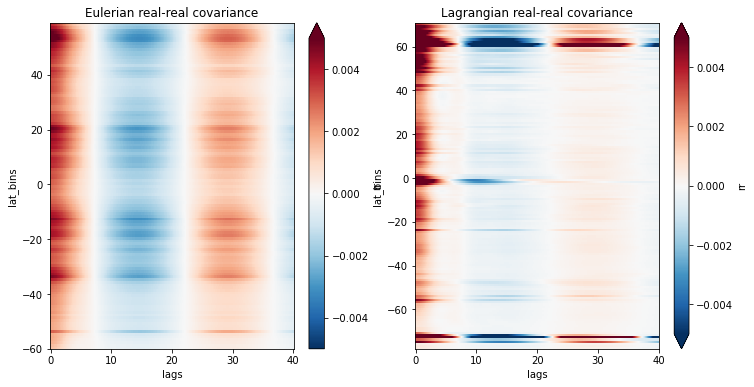

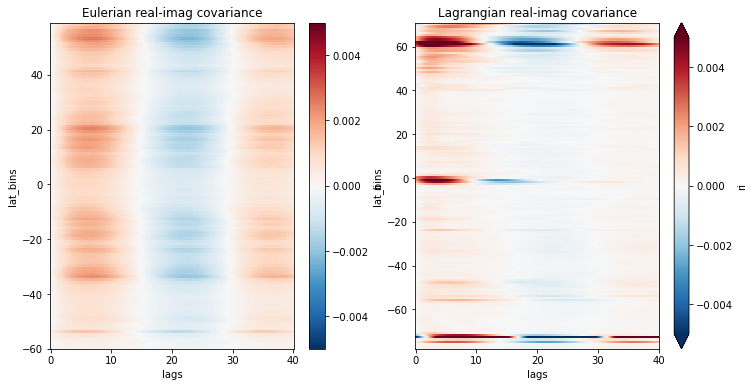

In [14]:
# test 1°
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE_dl1.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL_dl1.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[1],vmax=0.005)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')

fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE_dl1.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL_dl1.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[1],vmax=0.005)
axs[0].set_title('Eulerian real-imag covariance')
axs[1].set_title('Lagrangian real-imag covariance')

Text(0.5, 1.0, 'Lagrangian real-imag covariance')

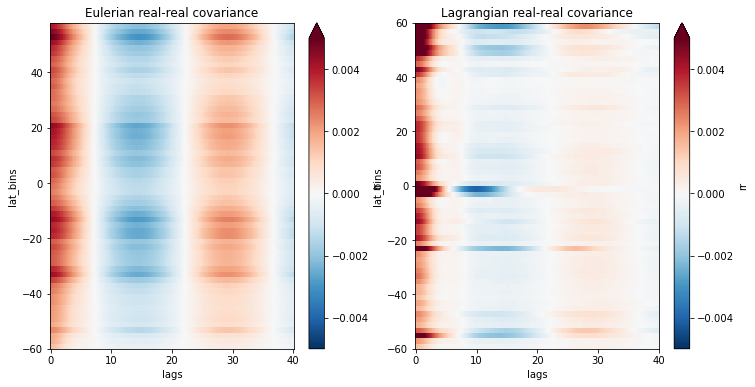

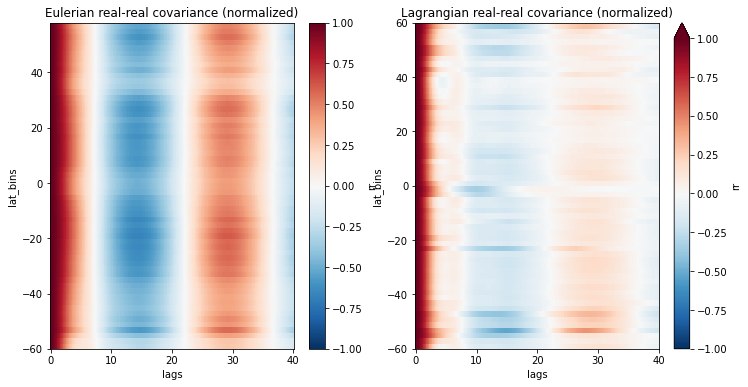

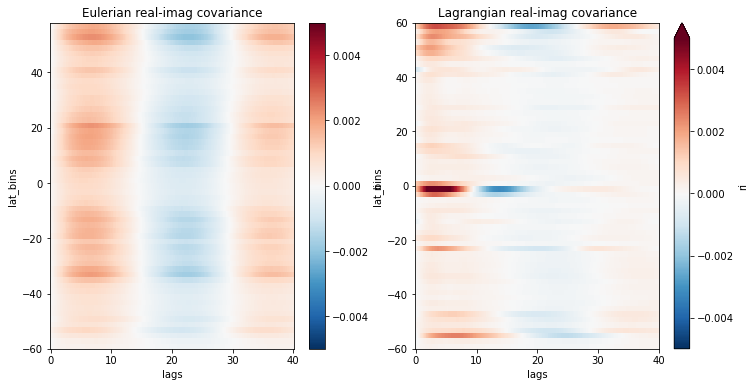

In [15]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[1],vmax=0.005)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')

fig,axs = plt.subplots(1,2,figsize=(12,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[0],vmax=1)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
axs[0].set_title('Eulerian real-real covariance (normalized)')
axs[1].set_title('Lagrangian real-real covariance (normalized)')

fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[1],vmax=0.005)
axs[0].set_title('Eulerian real-imag covariance')
axs[1].set_title('Lagrangian real-imag covariance')

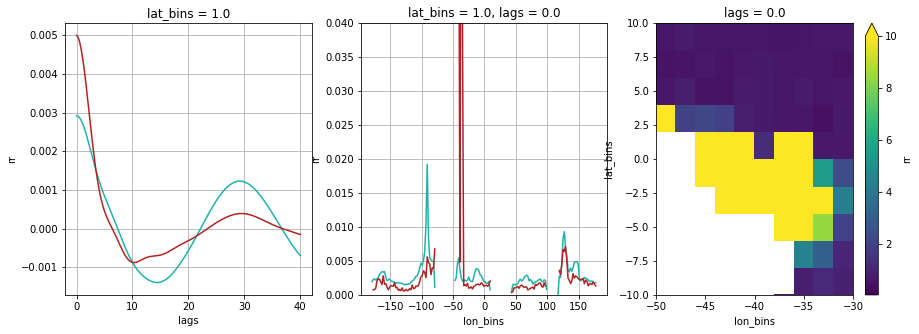

In [16]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
dsE.mean('lon_bins').sel(lat_bins=1.).rr.plot(ax=ax[0],c='lightseagreen')
dsL.mean('lon_bins').sel(lat_bins=1.).rr.plot(ax=ax[0],c='firebrick')
ax[0].grid()
dsE.sel(lat_bins=1.).rr.isel(lags=0).plot(ax=ax[1],c='lightseagreen')
dsL.sel(lat_bins=1.).rr.isel(lags=0).plot(ax=ax[1],c='firebrick')
ax[1].grid();ax[1].set_ylim(0,0.04);
ratio.plot(ylim=(-10,10),xlim=(-50,-30),vmax=10,ax=ax[2])

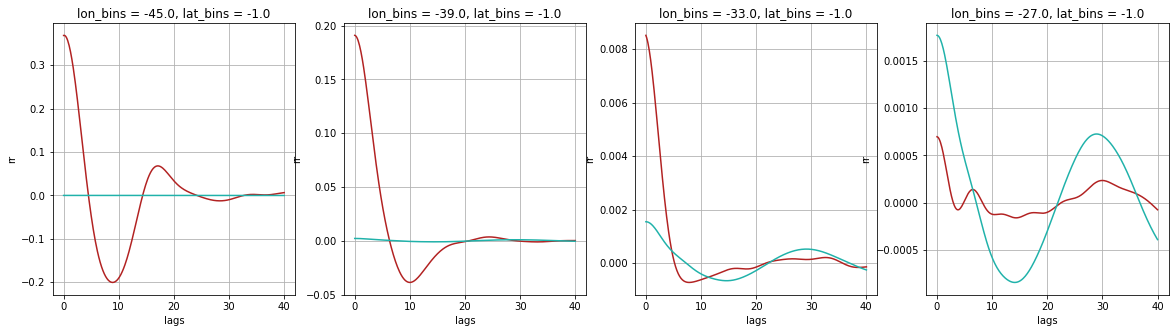

In [17]:
lat0 = -1.
dsL_sub = dsL.sel(lat_bins=lat0,lon_bins=slice(-45,-25,3))
dsE_sub = dsE.sel(lat_bins=lat0,lon_bins=slice(-45,-25,3))

fig,axs = plt.subplots(1,dsE_sub.lon_bins.size,figsize=(5*dsE_sub.lon_bins.size,5))
for ax,loni in zip(axs,dsE_sub.lon_bins):
    dsL_sub.rr.sel(lon_bins=loni).plot(ax=ax,c='firebrick')
    dsE_sub.rr.sel(lon_bins=loni).plot(ax=ax,c='lightseagreen')
    ax.grid()

In [18]:
number = dsE.mean('lon_bins').rr.isel(lat_bins=slice(0,None,10)).lat_bins.size
cmap = plt.get_cmap('bone')
colors = [cmap(i) for i in np.linspace(0., .8, number)]

dsE_sub = dsE.mean('lon_bins').isel(lat_bins=slice(0,None,10))
dsL_sub = dsL.mean('lon_bins').isel(lat_bins=slice(0,None,10))

(-0.7, 1.1)

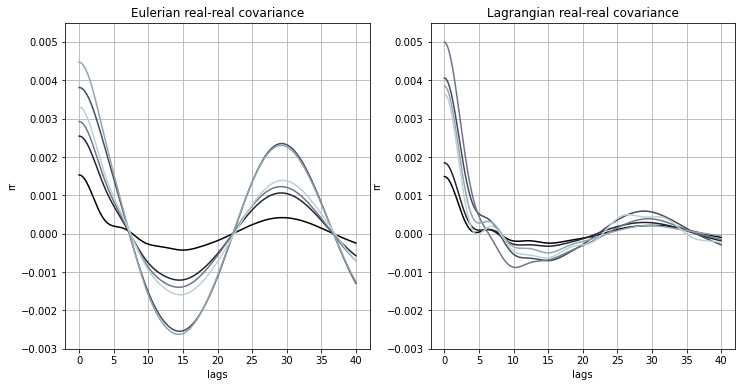

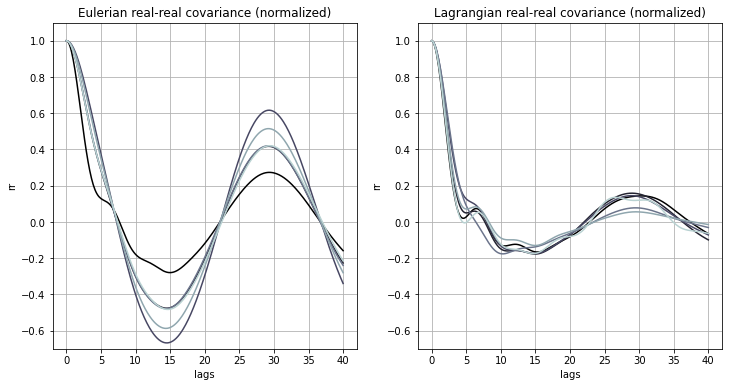

In [19]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for i,c in enumerate(colors):
    dsE_sub.rr.isel(lat_bins=i).plot(ax=axs[0],c=c)
    dsL_sub.rr.isel(lat_bins=i).plot(ax=axs[1],c=c)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[0].grid();axs[1].grid()
axs[0].set_ylim(-0.003,0.0055);axs[1].set_ylim(-0.003,0.0055)

fig,axs = plt.subplots(1,2,figsize=(12,6))
for i,c in enumerate(colors):
    (dsE_sub.rr/dsE_sub.rr.isel(lags=0)).isel(lat_bins=i).plot(ax=axs[0],c=c)
    (dsL_sub.rr/dsL_sub.rr.isel(lags=0)).isel(lat_bins=i).plot(ax=axs[1],c=c)
#(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).Crr.isel(lat_bins=slice(0,None,10)
#                                                                 ).plot(hue='lat_bins',ax=axs[0],add_legend=False)
#(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.isel(lat_bins=slice(0,None,10)
#                                                                ).plot(hue='lat_bins',ax=axs[1],add_legend=False)
axs[0].set_title('Eulerian real-real covariance (normalized)')
axs[1].set_title('Lagrangian real-real covariance (normalized)')
axs[0].grid();axs[1].grid();axs[0].set_ylim(-0.7,1.1);axs[1].set_ylim(-0.7,1.1)

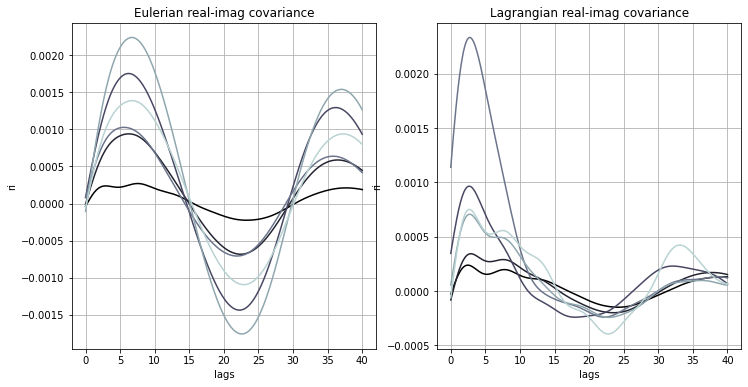

In [20]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for i,c in enumerate(colors):
    dsE_sub.ri.isel(lat_bins=i).plot(ax=axs[0],c=c)
    dsL_sub.ri.isel(lat_bins=i).plot(ax=axs[1],c=c)
axs[0].set_title('Eulerian real-imag covariance');axs[0].grid()
axs[1].set_title('Lagrangian real-imag covariance');axs[1].grid()

Text(0.5, 1.0, 'Lagrangian real-real variance')

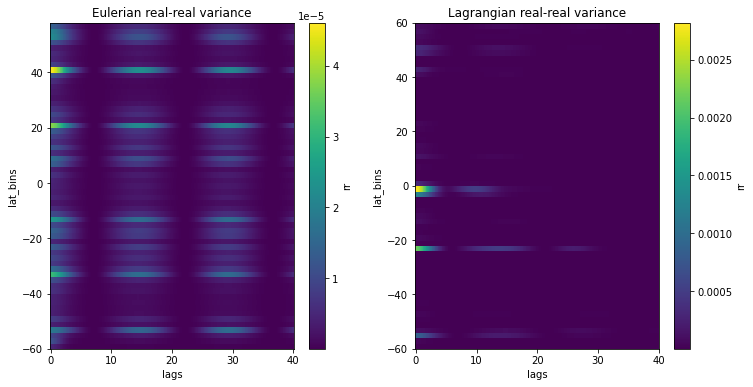

In [21]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.var('lon_bins').rr.plot(y='lat_bins',ax=axs[0])
dsL.var('lon_bins').rr.plot(y='lat_bins',ax=axs[1])
axs[0].set_title('Eulerian real-real variance')
axs[1].set_title('Lagrangian real-real variance')

#### Area of interest

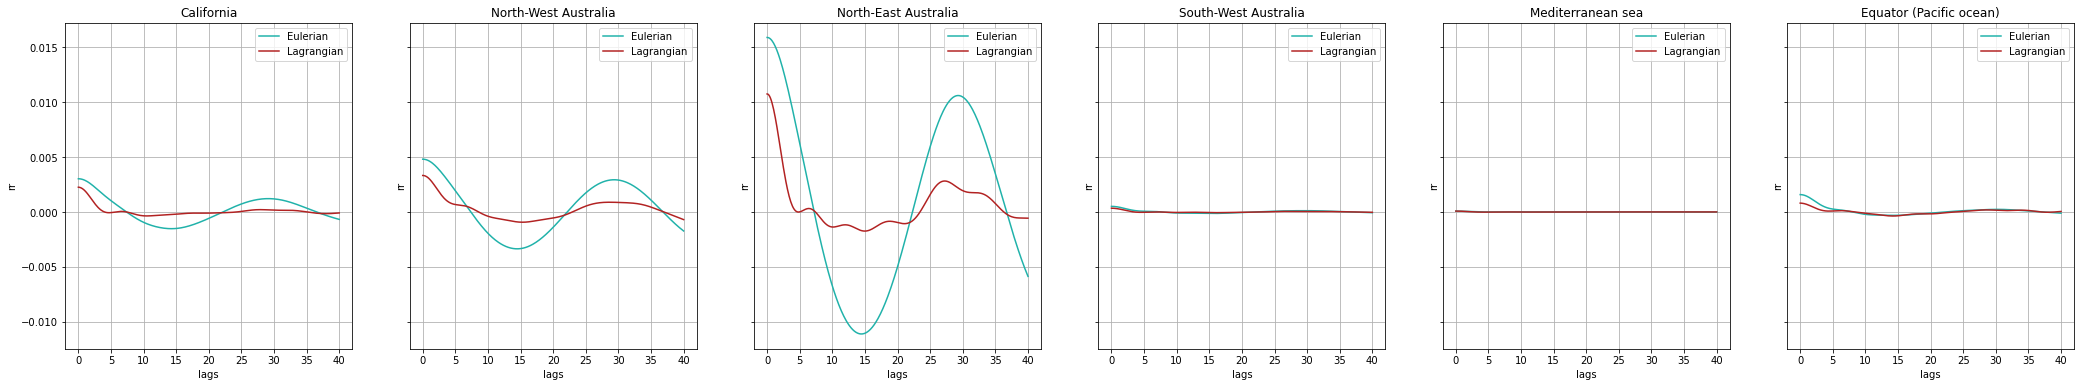

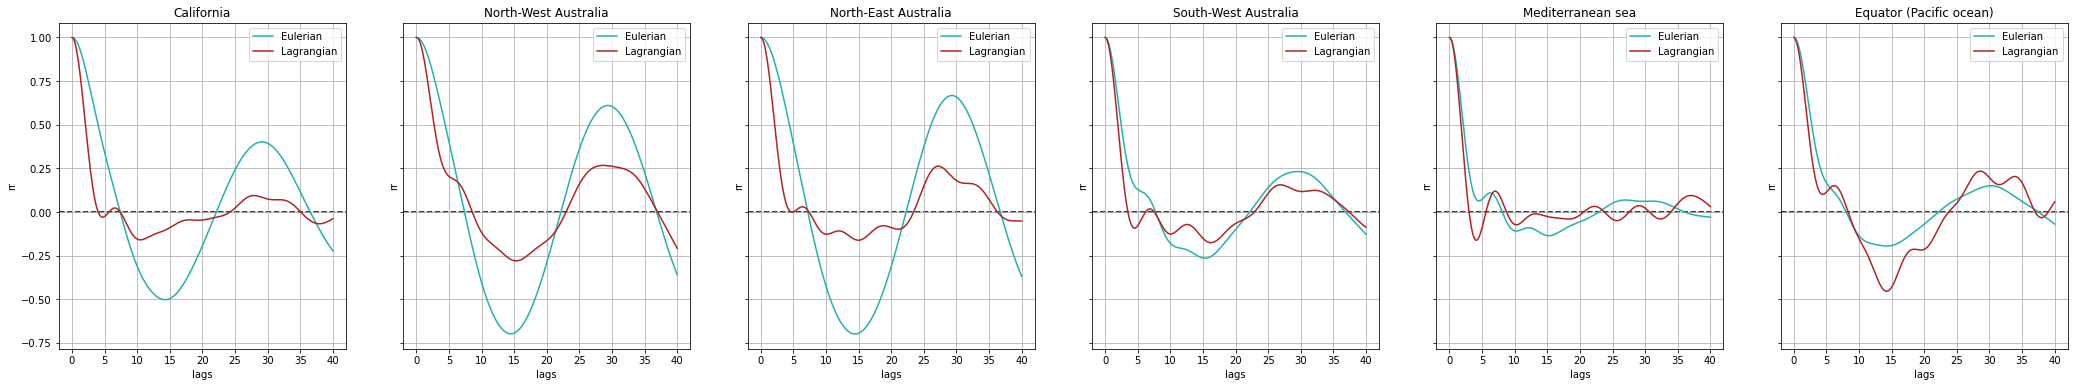

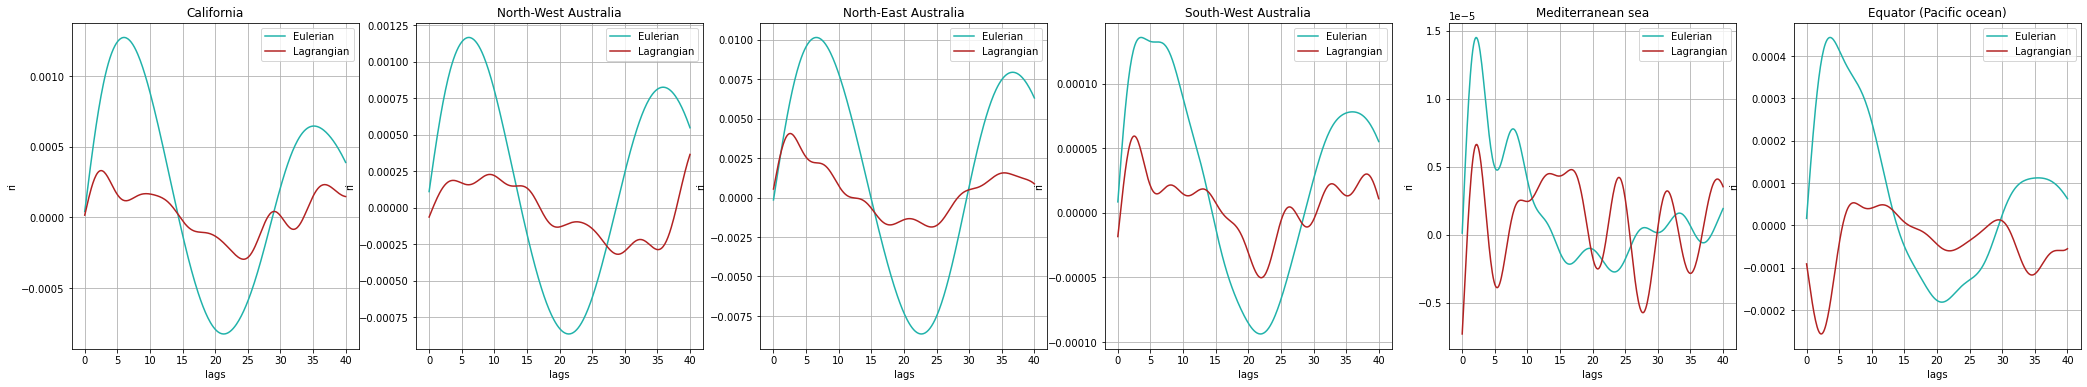

In [22]:
bbox = [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]
titles = ['California', 'North-West Australia','North-East Australia',
          'South-West Australia','Mediterranean sea','Equator (Pacific ocean)']

fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=True)
for i,title in zip(range(len(bbox)),titles):
    dsE.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    
fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=True)
for i,title in zip(range(len(bbox)),titles):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    (dsL/dsL.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    ax[i].axhline(0,c='k',zorder=0,linestyle='--')
    
fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=False)
for i,title in zip(range(len(bbox)),titles):
    dsE.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').ri.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').ri.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend();
    ax[i].set_title(title);

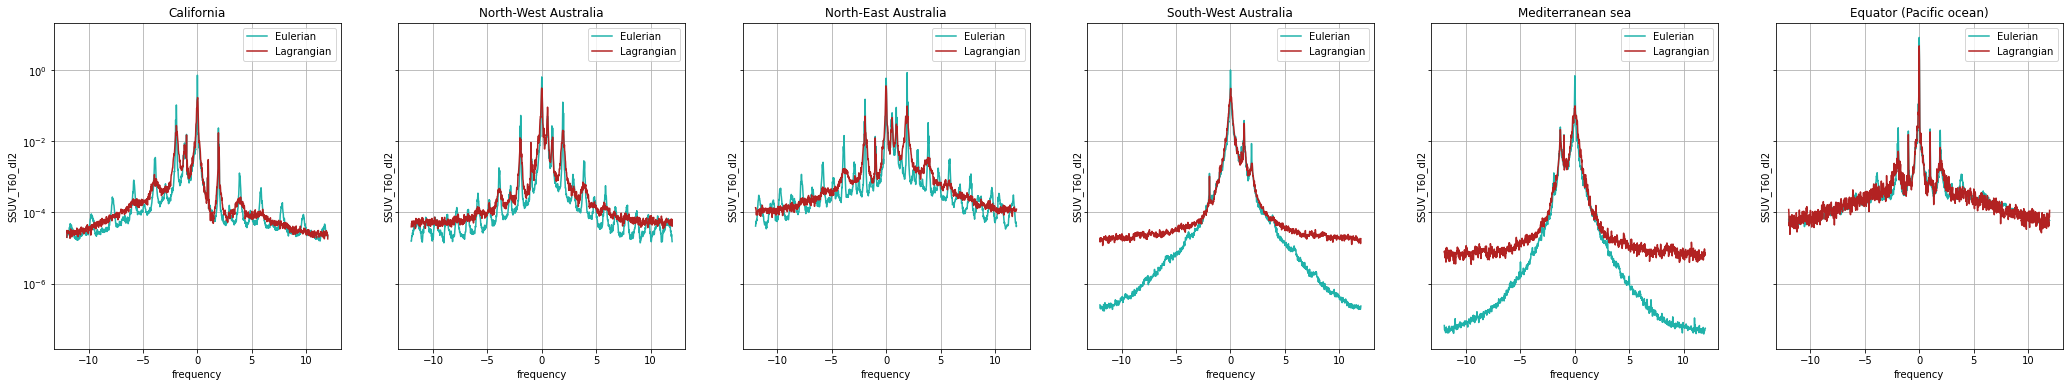

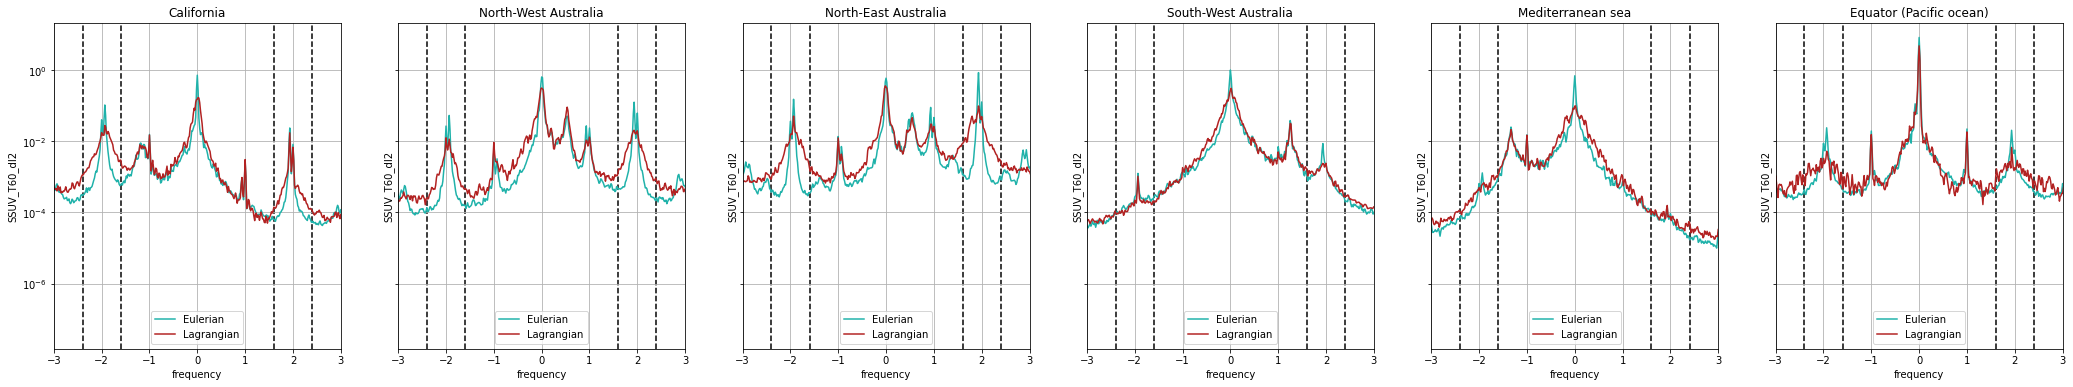

In [23]:
fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=True)
for i,title in zip(range(len(bbox)),titles):
    E_SSUV.SSUV_T60_dl2.sel(lat=bbox[i][1],lon=bbox[i][0],method='nearest'
                           ).plot(yscale='log',ax=ax[i],c='lightseagreen',label='Eulerian');
    L_SSUV.SSUV_T60_dl2.sel(lat=bbox[i][1],lon=bbox[i][0],method='nearest'
                           ).plot(yscale='log',ax=ax[i],c='firebrick',label='Lagrangian');
    ax[i].grid();ax[i].set_title(title);ax[i].legend()
    
fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=True)
for i,title in zip(range(len(bbox)),titles):
    E_SSUV.SSUV_T60_dl2.sel(lat=bbox[i][1],lon=bbox[i][0],method='nearest'
                           ).plot(yscale='log',ax=ax[i],c='lightseagreen',label='Eulerian');
    L_SSUV.SSUV_T60_dl2.sel(lat=bbox[i][1],lon=bbox[i][0],method='nearest'
                           ).plot(yscale='log',ax=ax[i],c='firebrick',label='Lagrangian');
    ax[i].grid();ax[i].set_title(title);ax[i].set_xlim(-3,3);ax[i].legend()
    ax[i].axvline(1.6,c='k',linestyle='--',zorder=0);ax[i].axvline(2.4,c='k',linestyle='--',zorder=0)
    ax[i].axvline(-1.6,c='k',linestyle='--',zorder=0);ax[i].axvline(-2.4,c='k',linestyle='--',zorder=0)

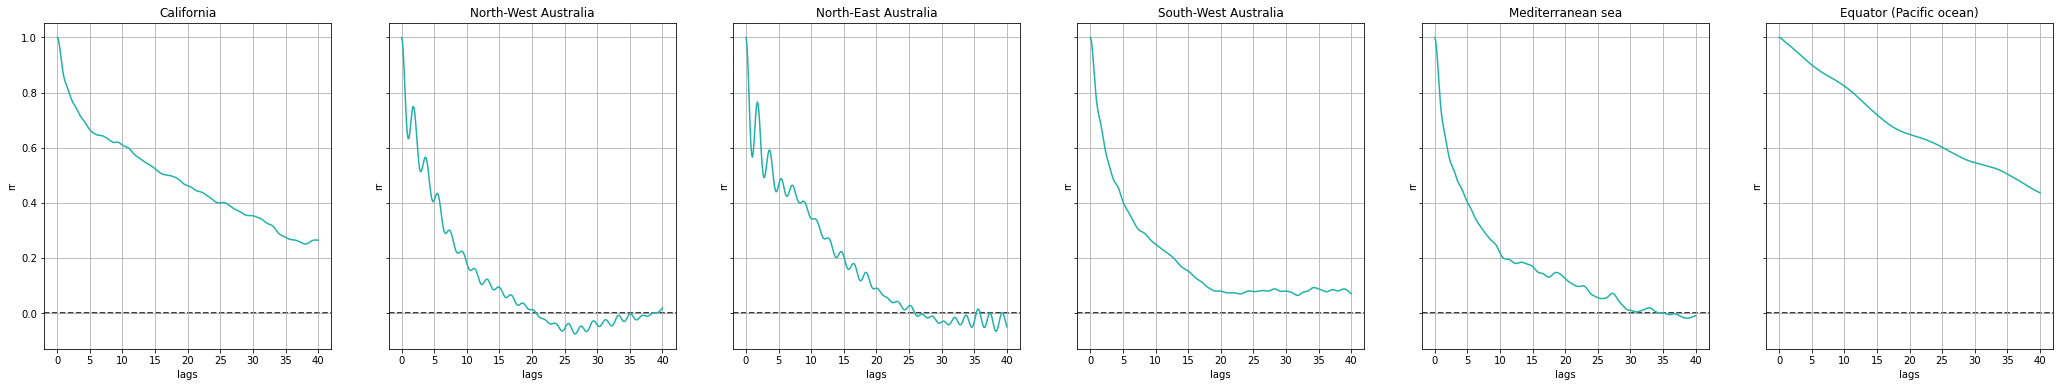

In [24]:
fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=True)
for i,title in zip(range(len(bbox)),titles):
    (dsE_low/dsE_low.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    ax[i].set_title(title);ax[i].grid()
    ax[i].axhline(0,c='k',zorder=0,linestyle='--')

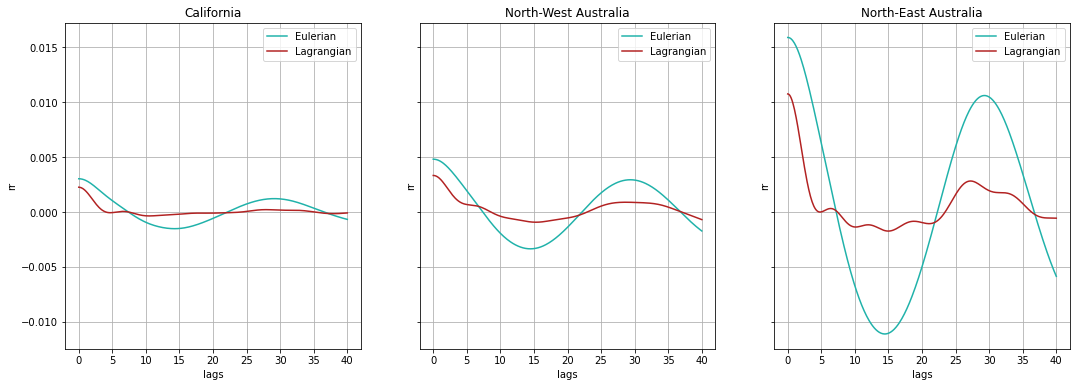

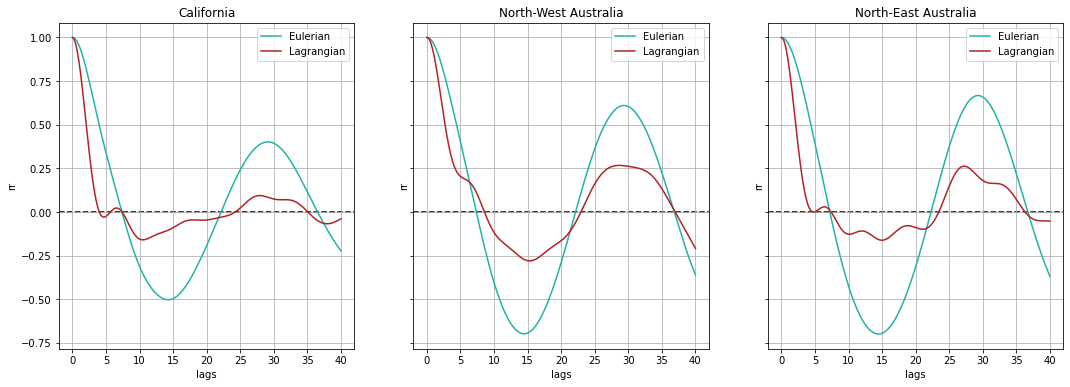

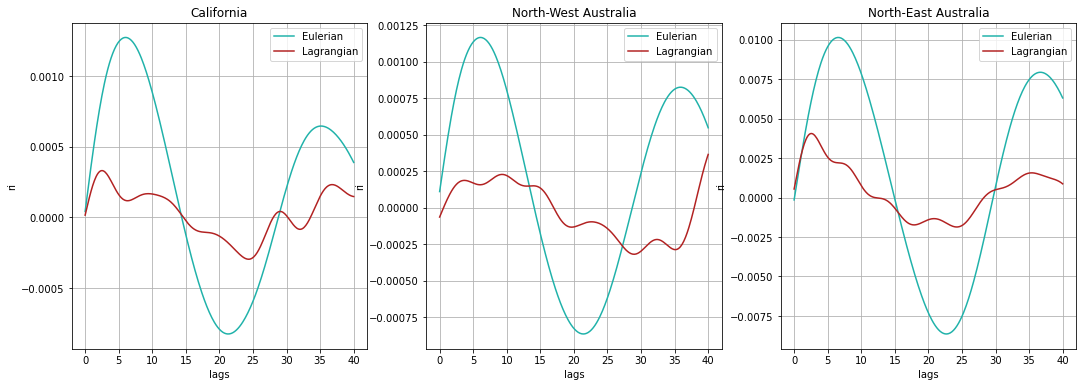

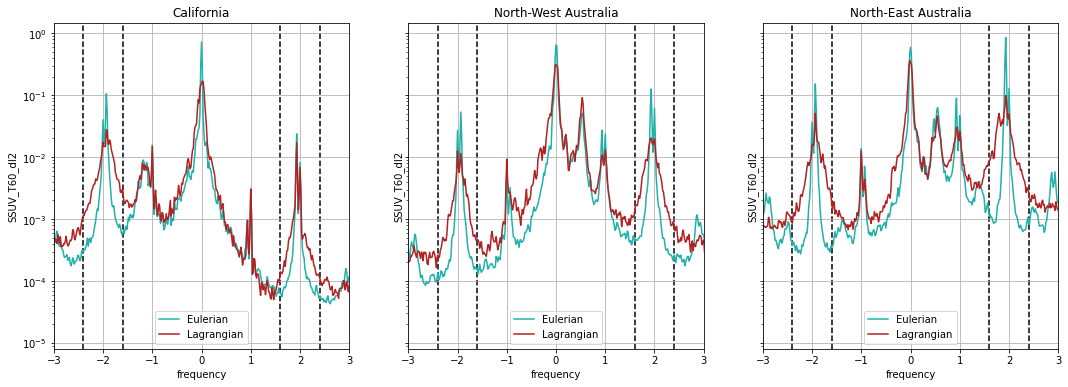

In [25]:
fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=True)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    dsE.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    
fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=True)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    (dsL/dsL.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    ax[i].axhline(0,c='k',zorder=0,linestyle='--')

fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=False)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    dsE.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').ri.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').ri.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend();
    ax[i].set_title(title);

fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=True)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    E_SSUV.SSUV_T60_dl2.sel(lat=bbox[i][1],lon=bbox[i][0],method='nearest'
                           ).plot(yscale='log',ax=ax[i],c='lightseagreen',label='Eulerian');
    L_SSUV.SSUV_T60_dl2.sel(lat=bbox[i][1],lon=bbox[i][0],method='nearest'
                           ).plot(yscale='log',ax=ax[i],c='firebrick',label='Lagrangian');
    ax[i].grid();ax[i].set_title(title);ax[i].set_xlim(-3,3);ax[i].legend()
    ax[i].axvline(1.6,c='k',linestyle='--',zorder=0);ax[i].axvline(2.4,c='k',linestyle='--',zorder=0)
    ax[i].axvline(-1.6,c='k',linestyle='--',zorder=0);ax[i].axvline(-2.4,c='k',linestyle='--',zorder=0)

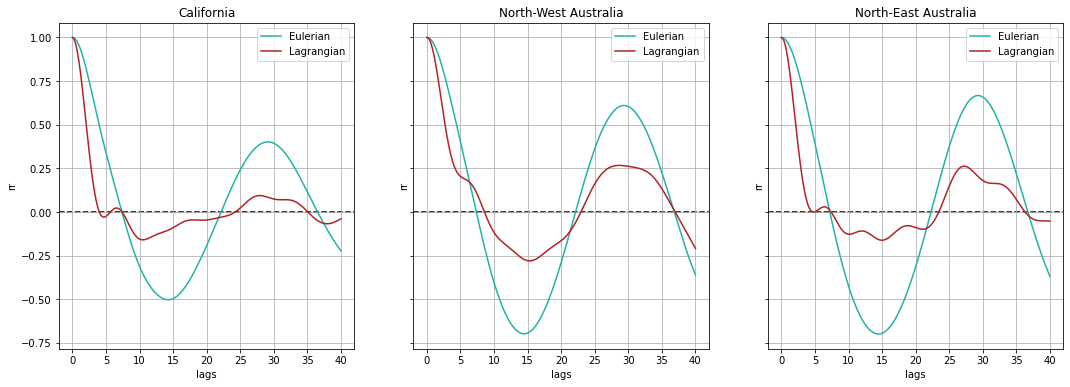

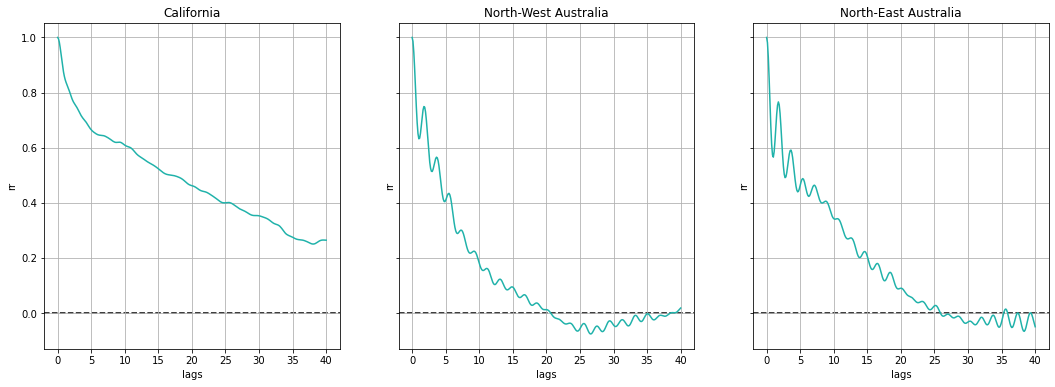

In [26]:
   
fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=True)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    (dsL/dsL.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    ax[i].axhline(0,c='k',zorder=0,linestyle='--')

fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=True)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    (dsE_low/dsE_low.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    ax[i].grid();
    ax[i].set_title(title)
    ax[i].axhline(0,c='k',zorder=0,linestyle='--')



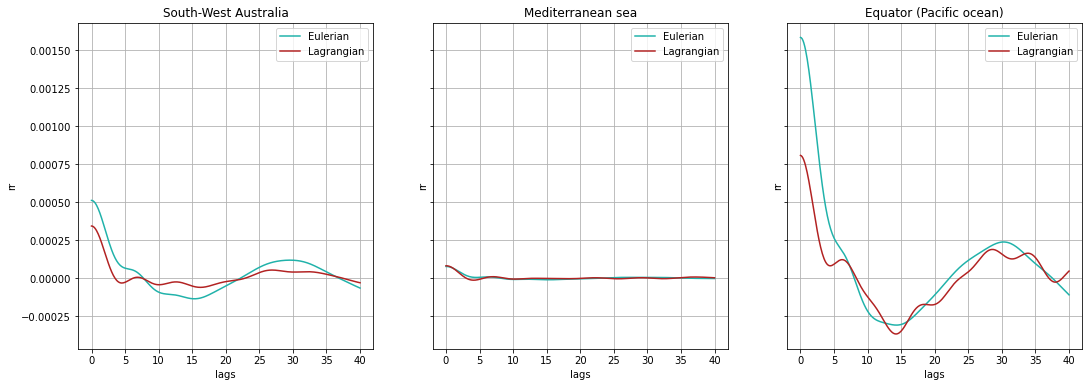

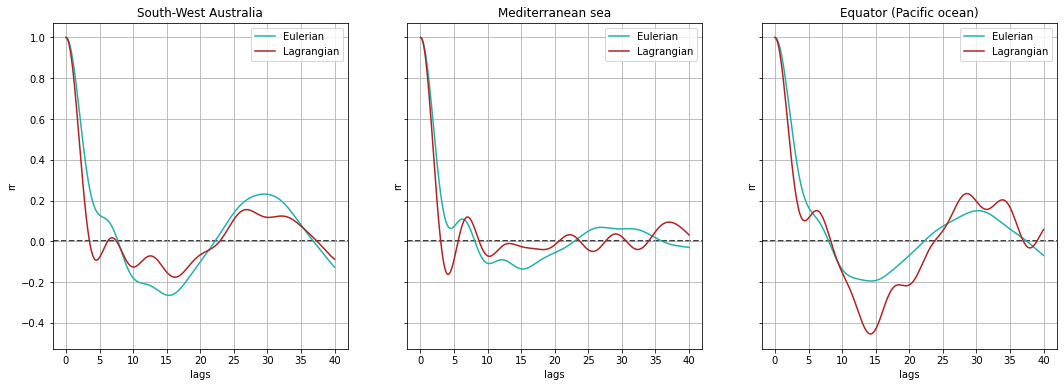

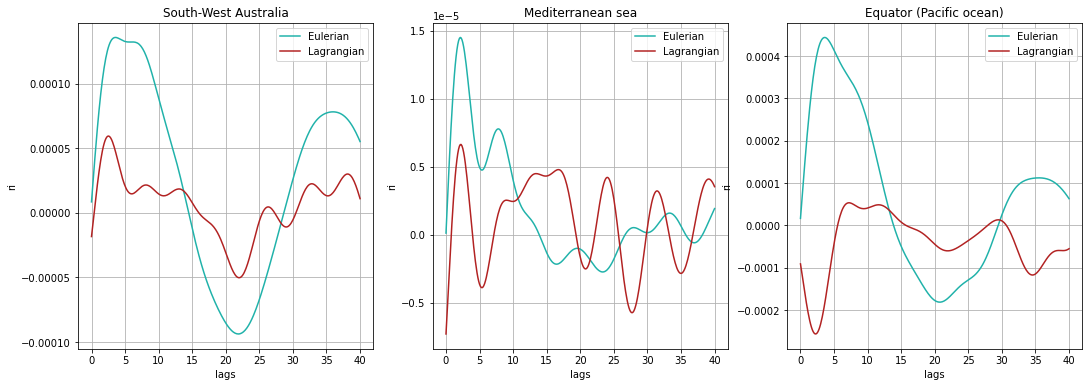

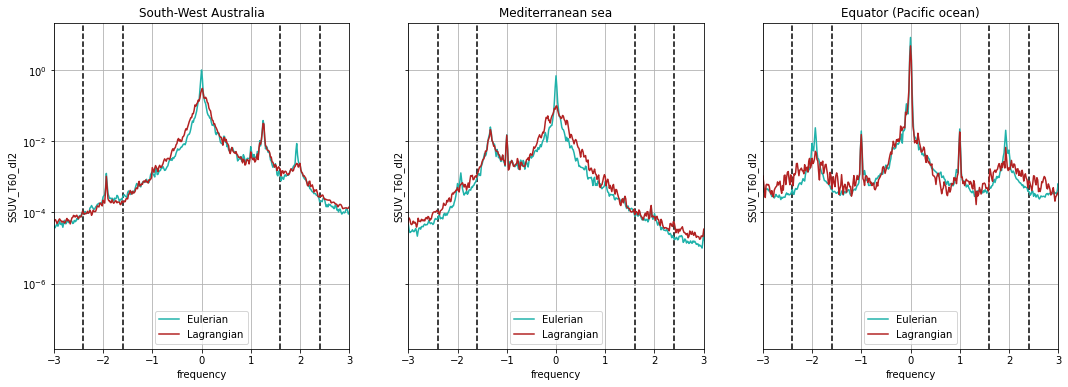

In [27]:
fig,ax = plt.subplots(1,len(bbox[3:]),figsize=(6*len(bbox[3:]),6),sharey=True)
for b,a,title in zip(bbox[3:],ax,titles[3:]):
    dsE.sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='firebrick',label='Lagrangian')
    a.grid();a.legend()
    a.set_title(title)
    
fig,ax = plt.subplots(1,len(bbox[3:]),figsize=(6*len(bbox[3:]),6),sharey=True)
for b,a,title in zip(bbox[3:],ax,titles[3:]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='lightseagreen',label='Eulerian')
    (dsL/dsL.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='firebrick',label='Lagrangian')
    a.grid();a.legend()
    a.set_title(title)
    a.axhline(0,c='k',zorder=0,linestyle='--')

fig,ax = plt.subplots(1,len(bbox[3:]),figsize=(6*len(bbox[3:]),6),sharey=False)
for b,a,title in zip(bbox[3:],ax,titles[3:]):
    dsE.sel(lat_bins=b[1],lon_bins=b[0],method='nearest').ri.plot(ax=a,c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=b[1],lon_bins=b[0],method='nearest').ri.plot(ax=a,c='firebrick',label='Lagrangian')
    a.grid();a.legend();
    a.set_title(title);

fig,ax = plt.subplots(1,len(bbox[3:]),figsize=(6*len(bbox[3:]),6),sharey=True)
for b,a,title in zip(bbox[3:],ax,titles[3:]):
    E_SSUV.SSUV_T60_dl2.sel(lat=b[1],lon=b[0],method='nearest'
                           ).plot(yscale='log',ax=a,c='lightseagreen',label='Eulerian');
    L_SSUV.SSUV_T60_dl2.sel(lat=b[1],lon=b[0],method='nearest'
                           ).plot(yscale='log',ax=a,c='firebrick',label='Lagrangian');
    a.grid();a.set_title(title);a.set_xlim(-3,3);a.legend()
    a.axvline(1.6,c='k',linestyle='--',zorder=0);a.axvline(2.4,c='k',linestyle='--',zorder=0)
    a.axvline(-1.6,c='k',linestyle='--',zorder=0);a.axvline(-2.4,c='k',linestyle='--',zorder=0)

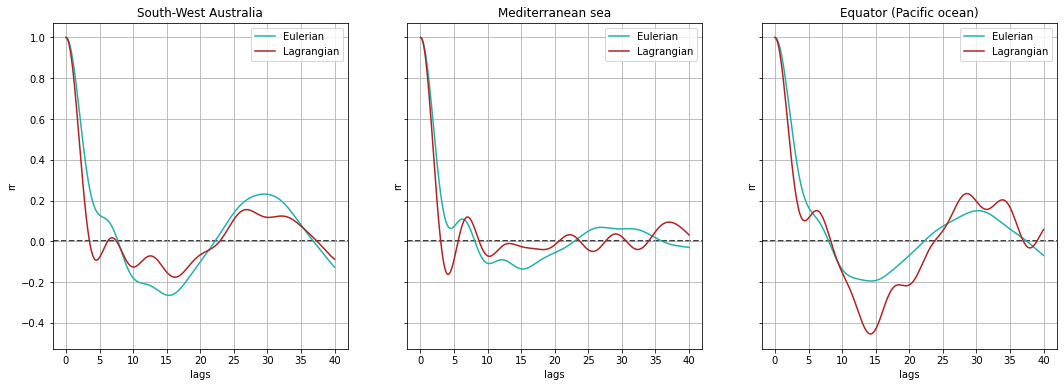

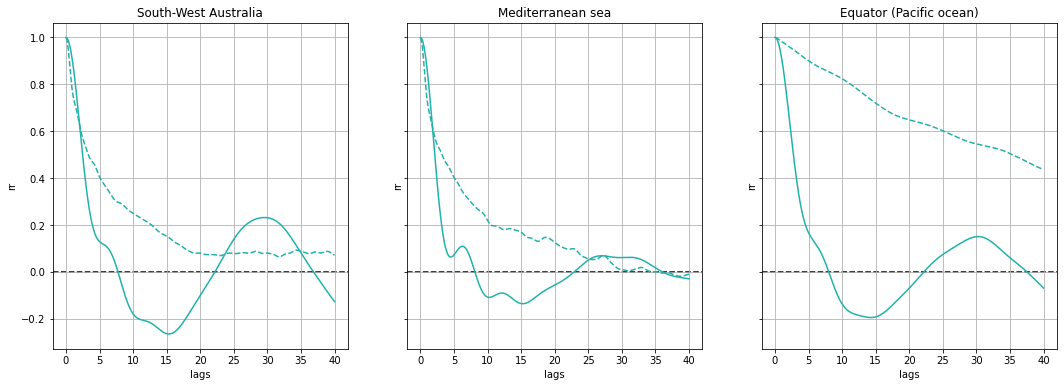

In [59]:
fig,ax = plt.subplots(1,len(bbox[3:]),figsize=(6*len(bbox[3:]),6),sharey=True)
for b,a,title in zip(bbox[3:],ax,titles[3:]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='lightseagreen',label='Eulerian')
    (dsL/dsL.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='firebrick',label='Lagrangian')
    a.grid();a.legend()
    a.set_title(title)
    a.axhline(0,c='k',zorder=0,linestyle='--')
    
fig,ax = plt.subplots(1,len(bbox[3:]),figsize=(6*len(bbox[3:]),6),sharey=True)
for b,a,title in zip(bbox[3:],ax,titles[3:]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest'
                              ).rr.plot(ax=a,c='lightseagreen',label='Eulerian: high frequency')
    (dsE_low/dsE_low.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest'
                                      ).rr.plot(ax=a,c='lightseagreen',linestyle='--',label='Eulerian : low frequency')
    a.grid();
    a.set_title(title)
    a.axhline(0,c='k',zorder=0,linestyle='--')

#### Estimation of decorrelation timescale

In [29]:
b0 = bbox_nea
b1 = bbox_cal

In [30]:
Crr_E = (dsE/dsE.isel(lags=0)).rr
Crr_L = (dsL/dsL.isel(lags=0)).rr

In [31]:
Crr_E_nea = Crr_E.sel(lat_bins=b0[1],lon_bins=b0[0],method='nearest')
Crr_E_cal = Crr_E.sel(lat_bins=b1[1],lon_bins=b1[0],method='nearest')

In [32]:
p1 = Crr_E_nea.where(Crr_E_nea==Crr_E_nea.sel(lags=slice(15,None)).max(),drop=True)
a, b= (p1-1).values/(p1.lags).values,1

p1_cal = Crr_E_cal.where(Crr_E_cal==Crr_E_cal.sel(lags=slice(15,None)).max(),drop=True)
a_cal, b_cal = (p1_cal-1).values/(p1_cal.lags).values,1

In [33]:
print('(Very) roughly estimated decorraletion timescale NEA : ',(-b)/a)
print('(Very) roughly estimated decorraletion timescale California: ',(-b_cal)/a_cal)

(Very) roughly estimated decorraletion timescale NEA :  [87.92471169]
(Very) roughly estimated decorraletion timescale California:  [48.67291497]


In [34]:
# From the sum of autocorrelation : 
print('(Very) roughly estimated decorraletion timescale NEA : ',(Crr_E_nea**2).sum('lags').values)
print('(Very) roughly estimated decorraletion timescale California : ',(Crr_E_cal**2).sum('lags').values)

(Very) roughly estimated decorraletion timescale NEA :  83.21821750577516
(Very) roughly estimated decorraletion timescale California :  48.678052406638315


In [35]:
T = (Crr_E**2).sel(lags=slice(0,30)).sum('lags')

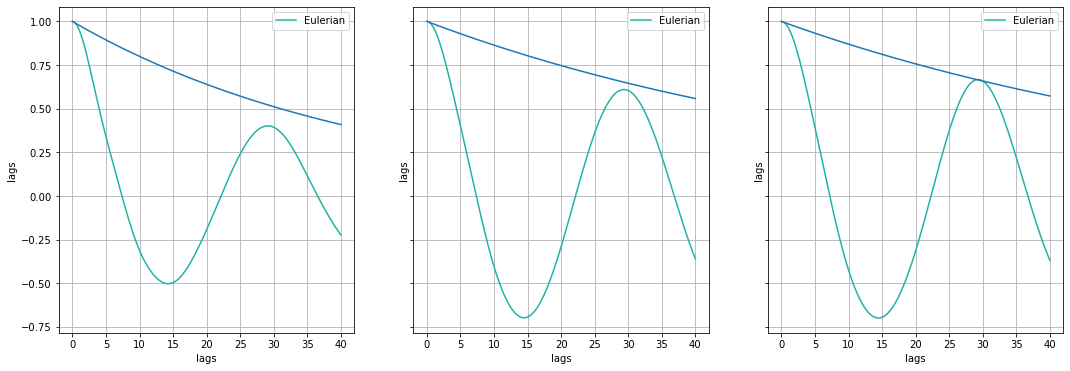

In [36]:
fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=True)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
#    dsL.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend();
    ax[i].set_title(title+' : %s'%T.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').values);
    np.exp(-dsE.lags/T.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').values).plot(ax=ax[i])

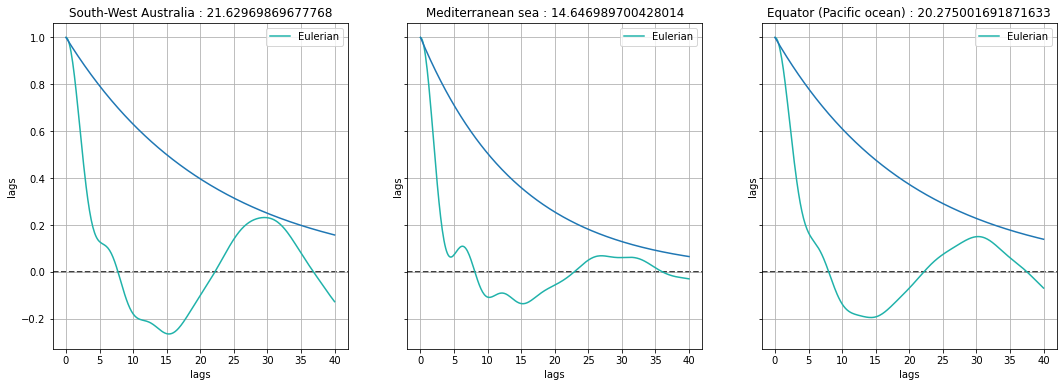

In [37]:
fig,ax = plt.subplots(1,len(bbox[3:]),figsize=(6*len(bbox[3:]),6),sharey=True)
for bb,a,title in zip(bbox[3:],ax,titles[3:]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=bb[1],lon_bins=bb[0],method='nearest').rr.plot(ax=a,c='lightseagreen',label='Eulerian')
#    (dsL/dsL.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='firebrick',label='Lagrangian')
    a.grid();a.legend();
    np.exp(-dsE.lags/T.sel(lat_bins=bb[1],lon_bins=bb[0],method='nearest').values).plot(ax=a)
    a.set_title(title+' : %s'%T.sel(lat_bins=bb[1],lon_bins=bb[0],method='nearest').values);
    a.axhline(0,c='k',zorder=0,linestyle='--')



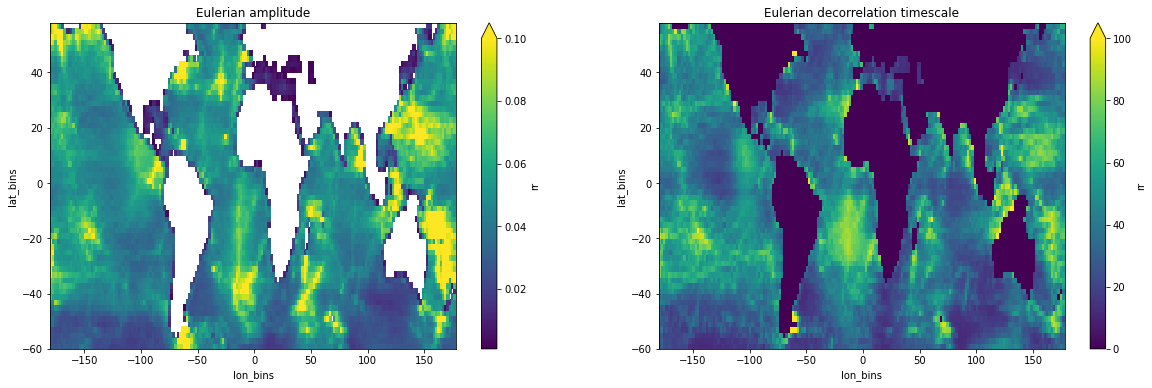

In [38]:
fig,axs = plt.subplots(1,2,figsize=(20,6))
np.sqrt(dsE.isel(lags=0).rr).plot(x='lon_bins',ax=axs[0],vmax=0.1)
T.plot(x='lon_bins',ax=axs[1],vmax=100)
axs[0].set_title('Eulerian amplitude');
axs[1].set_title('Eulerian decorrelation timescale');

In [39]:
TL = (Crr_L**2).sel(lags=slice(0,30)).sum('lags')

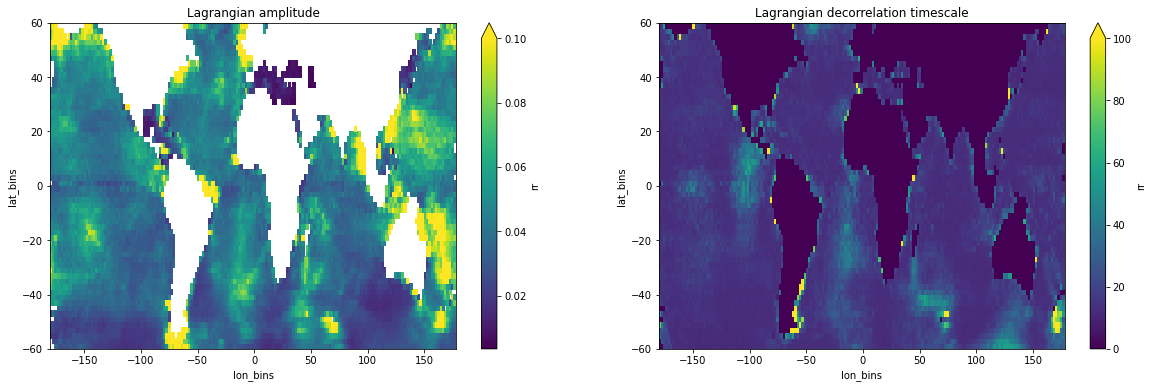

In [40]:
fig,axs = plt.subplots(1,2,figsize=(20,6))
np.sqrt(dsL.isel(lags=0).rr).plot(x='lon_bins',ax=axs[0],vmax=0.1)
TL.plot(x='lon_bins',ax=axs[1],vmax=100)
axs[0].set_title('Lagrangian amplitude');
axs[1].set_title('Lagrangian decorrelation timescale');

In [50]:
T_low = ((dsE_low/dsE_low.isel(lags=0)).rr**2).sel(lags=slice(0,30)).sum('lags')

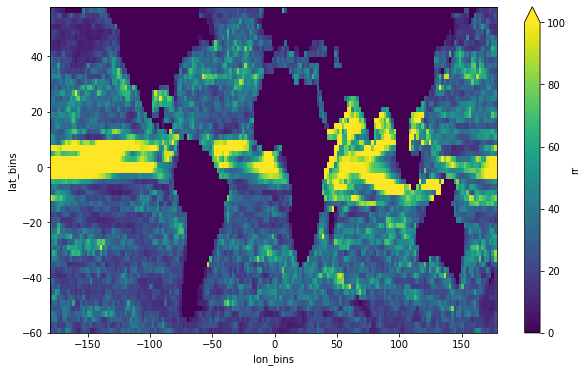

In [55]:
T_low.plot(y='lat_bins',vmax=100,figsize=(10,6))

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/plot/plot.py:959: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  primitive = ax.pcolormesh(x, y, z, **kwargs)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


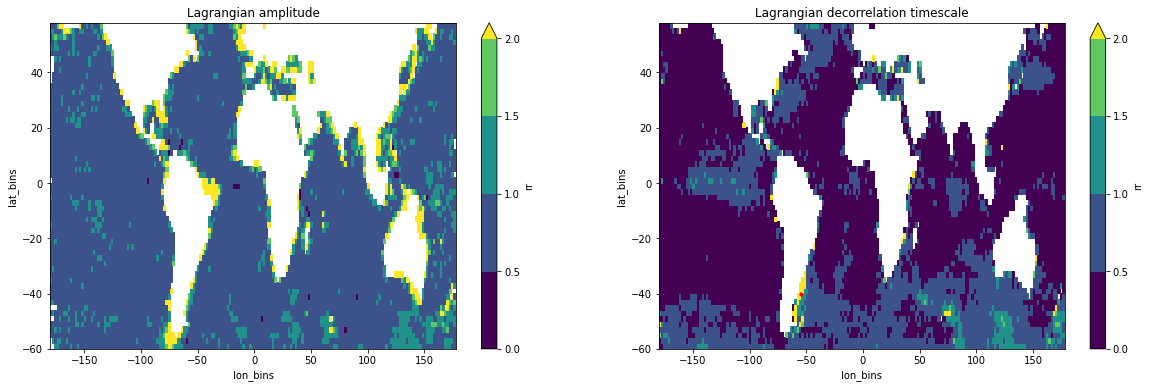

In [56]:
fig,axs = plt.subplots(1,2,figsize=(20,6))
(np.sqrt(dsL.isel(lags=0).rr)/np.sqrt(dsE.isel(lags=0).rr)).plot(x='lon_bins',ax=axs[0],levels=[0,0.5,1,1.5,2])
(TL/T).plot(x='lon_bins',ax=axs[1],levels=[0,0.5,1,1.5,2])
axs[0].set_title('Lagrangian amplitude');
axs[1].set_title('Lagrangian decorrelation timescale');
axs[1].scatter(-55,-40,c='r',s=10)

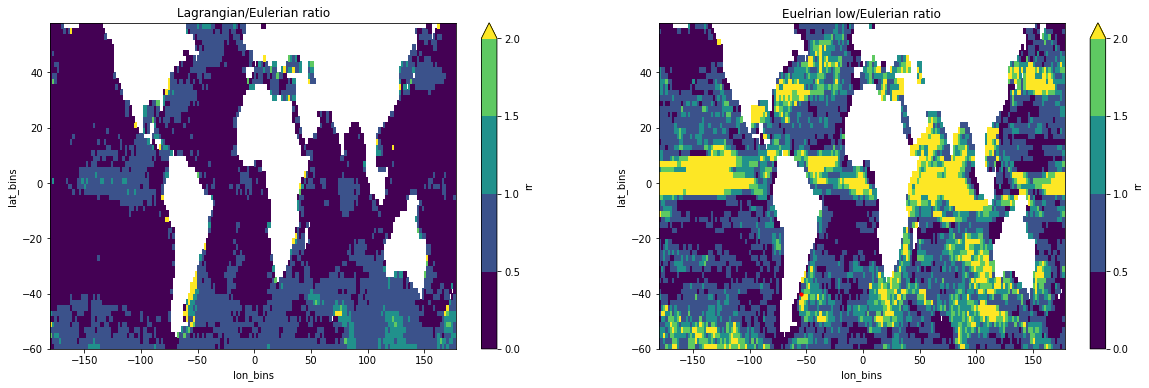

In [57]:
fig,axs = plt.subplots(1,2,figsize=(20,6))
(TL/T).plot(x='lon_bins',ax=axs[0],levels=[0,0.5,1,1.5,2])
(T_low/T).plot(x='lon_bins',ax=axs[1],levels=[0,0.5,1,1.5,2])
axs[0].set_title('Lagrangian/Eulerian ratio');
axs[1].set_title('Euelrian low/Eulerian ratio');
axs[1].scatter(-55,-40,c='r',s=10)

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


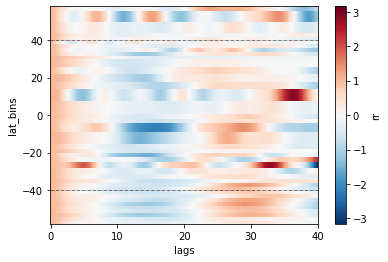

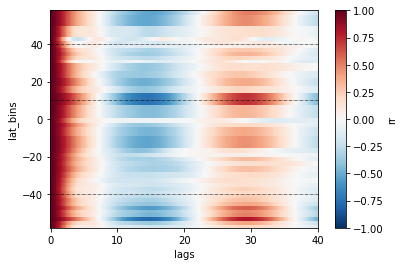

In [42]:
(dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.mean('lon_bins').dropna('lat_bins').plot()
plt.axhline(-40,c='k',linestyle='-.',linewidth='0.5');plt.axhline(40,c='k',linestyle='-.',linewidth='0.5')
plt.figure()
(dsE/dsE.isel(lags=0)).where(TL>1.5*T).rr.mean('lon_bins').dropna('lat_bins').plot(y='lat_bins')
plt.axhline(-40,c='k',linestyle='-.',linewidth='0.5');plt.axhline(40,c='k',linestyle='-.',linewidth='0.5')
plt.axhline(10,c='k',linestyle='-.',linewidth='0.5')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureW

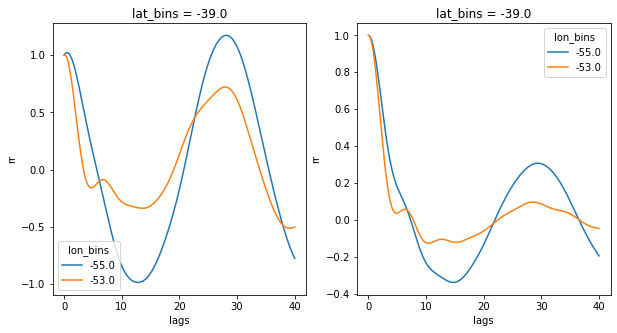

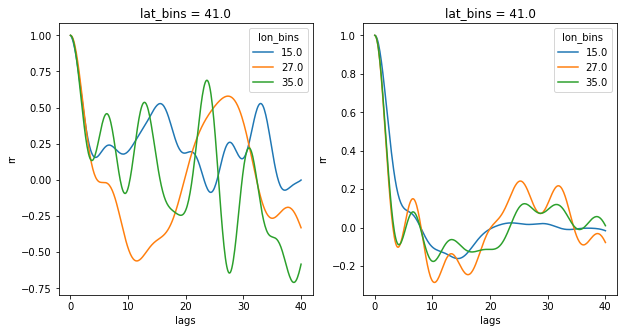

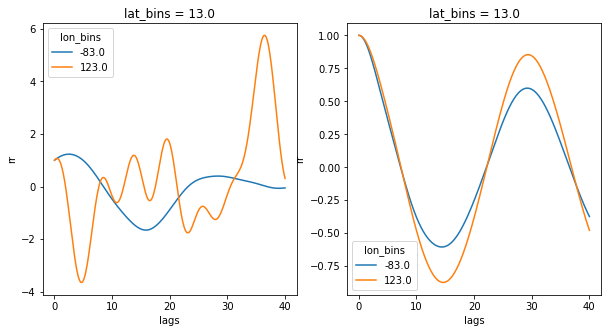

In [43]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
(dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=-40,method='nearest').dropna('lon_bins').plot(hue='lon_bins',ax=ax[0])
(dsE/dsE.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=-40,method='nearest').dropna('lon_bins').plot(hue='lon_bins',ax=ax[1])

fig,ax = plt.subplots(1,2,figsize=(10,5))
(dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=40,method='nearest').dropna('lon_bins').plot(hue='lon_bins',ax=ax[0])
(dsE/dsE.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=40,method='nearest').dropna('lon_bins').plot(hue='lon_bins',ax=ax[1])

fig,ax = plt.subplots(1,2,figsize=(10,5))
(dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=12,method='nearest').dropna('lon_bins').plot(hue='lon_bins',ax=ax[0])
(dsE/dsE.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=12,method='nearest').dropna('lon_bins').plot(hue='lon_bins',ax=ax[1])

In [44]:
lon40 = (dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=40,method='nearest').dropna('lon_bins').lon_bins.values
lon12 = (dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=12,method='nearest').dropna('lon_bins').lon_bins.values
lon_40 = (dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=-40,method='nearest').dropna('lon_bins').lon_bins.values

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


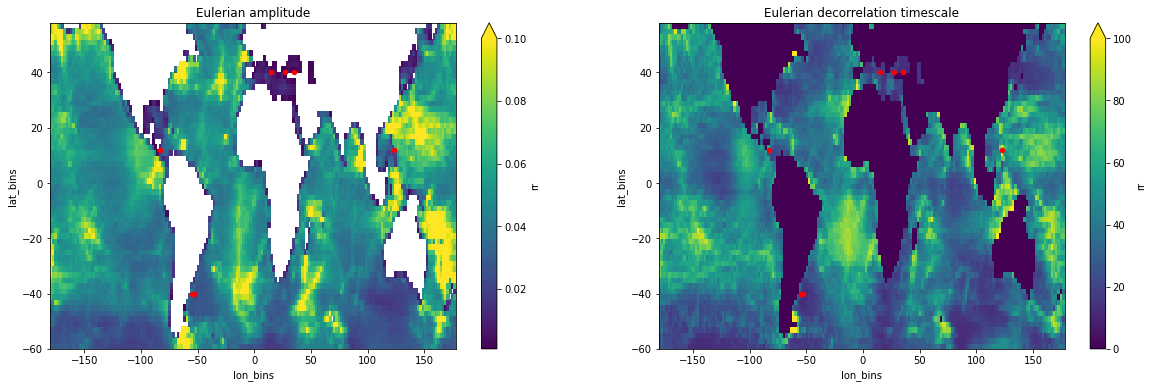

In [45]:
fig,axs = plt.subplots(1,2,figsize=(20,6))
np.sqrt(dsE.isel(lags=0).rr).plot(x='lon_bins',ax=axs[0],vmax=0.1)
T.plot(x='lon_bins',ax=axs[1],vmax=100)
axs[0].set_title('Eulerian amplitude');
axs[1].set_title('Eulerian decorrelation timescale');
axs[0].scatter(lon40,np.full(lon40.size,40),c='r',s=20)
axs[1].scatter(lon40,np.full(lon40.size,40),c='r',s=20)
axs[0].scatter(lon12,np.full(lon12.size,12),c='r',s=20)
axs[1].scatter(lon12,np.full(lon12.size,12),c='r',s=20)
axs[0].scatter(lon_40,np.full(lon_40.size,-40),c='r',s=20)
axs[1].scatter(lon_40,np.full(lon_40.size,-40),c='r',s=20)

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


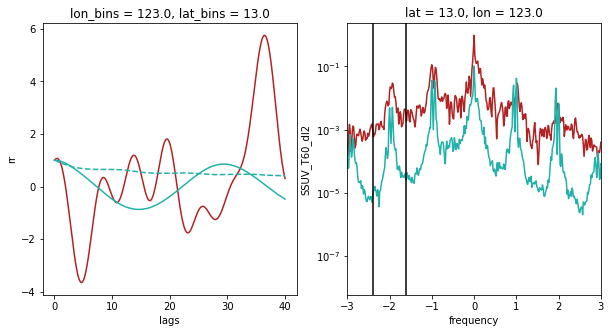

In [47]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
(dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=12,lon_bins=123,method='nearest'
                                             ).plot(ax=ax[0],c='firebrick')
(dsE/dsE.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=12,lon_bins=123,method='nearest'
                                             ).plot(ax=ax[0],c='lightseagreen')
(dsE_low/dsE_low.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=12,lon_bins=123,method='nearest'
                                             ).plot(ax=ax[0],c='lightseagreen',linestyle='--')
L_SSUV.SSUV_T60_dl2.sel(lat=12,lon=123,method='nearest'
                       ).plot(yscale='log',xlim=(-3,3),c='firebrick',ax=ax[1])
E_SSUV.SSUV_T60_dl2.sel(lat=12,lon=123,method='nearest'
                       ).plot(yscale='log',xlim=(-3,3),c='lightseagreen',ax=ax[1])
ax[1].axvline(-1.6,c='k');ax[1].axvline(-2.4,c='k')

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


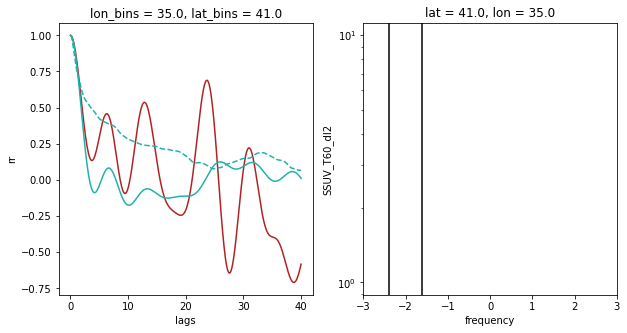

In [48]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
(dsL/dsL.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=41,lon_bins=35,method='nearest'
                                             ).plot(ax=ax[0],c='firebrick')
(dsE/dsE.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=41,lon_bins=35,method='nearest'
                                             ).plot(ax=ax[0],c='lightseagreen')
(dsE_low/dsE_low.isel(lags=0)).where(TL>1.5*T).rr.sel(lat_bins=41,lon_bins=35,method='nearest'
                                             ).plot(ax=ax[0],c='lightseagreen',linestyle='--')
L_SSUV.SSUV_T60_dl2.sel(lat=41,lon=35,method='nearest'
                       ).plot(yscale='log',xlim=(-3,3),c='firebrick',ax=ax[1])
E_SSUV.SSUV_T60_dl2.sel(lat=41,lon=35,method='nearest'
                       ).plot(yscale='log',xlim=(-3,3),c='lightseagreen',ax=ax[1])
ax[1].axvline(-1.6,c='k');ax[1].axvline(-2.4,c='k')

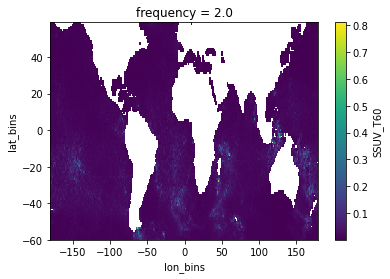

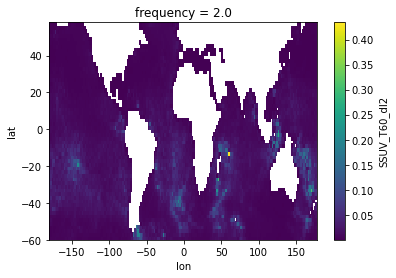

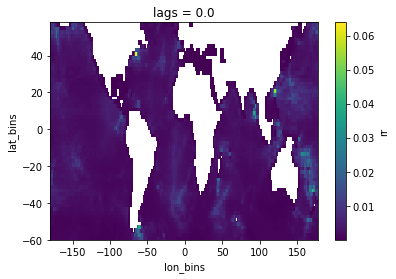

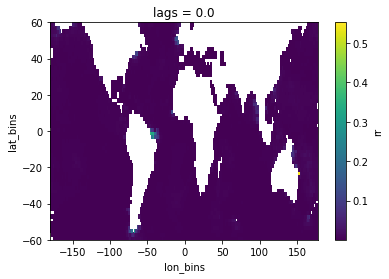

In [284]:
E_SSUV.SSUV_T60.sel(frequency=2).plot(x='lon_bins')
plt.figure()
E_SSUV.SSUV_T60_dl2.sel(frequency=2).plot(x='lon')
plt.figure()
dsE.isel(lags=0).rr.plot(x='lon_bins')
plt.figure()
dsL.isel(lags=0).rr.plot(x='lon_bins')

#### Bins near area of interest

Text(0.5, 1.0, 'Eulerian')

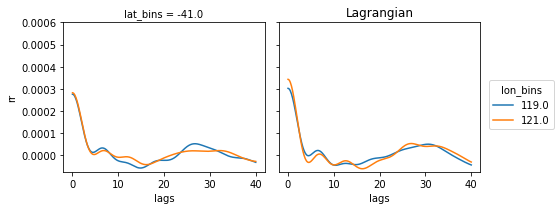

<Figure size 432x288 with 0 Axes>

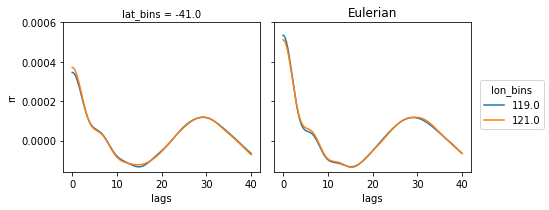

In [78]:
lonlim,latlim = [bbox_swa[0]-2,bbox_swa[0]+2],[bbox_swa[1]-2,bbox_swa[1]+2]

dsL.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(None,6e-4))
plt.title('Lagrangian')
plt.figure()
dsE.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(None,6e-4))
plt.title('Eulerian')

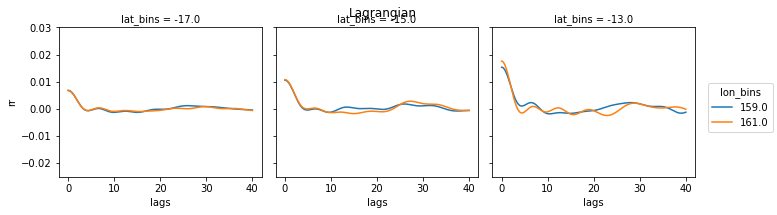

<Figure size 432x288 with 0 Axes>

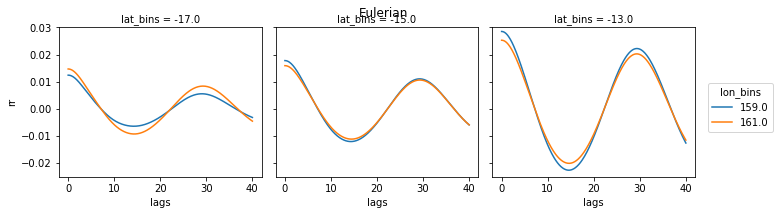

In [90]:
lonlim,latlim = [bbox_nea[0]-2,bbox_nea[0]+2],[bbox_nea[1]-2,bbox_nea[1]+2]

dsL.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(-0.025,30e-3))
plt.suptitle('Lagrangian')
plt.figure()
dsE.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(-0.025,30e-3))
plt.suptitle('Eulerian') 
fig.tight_layout()

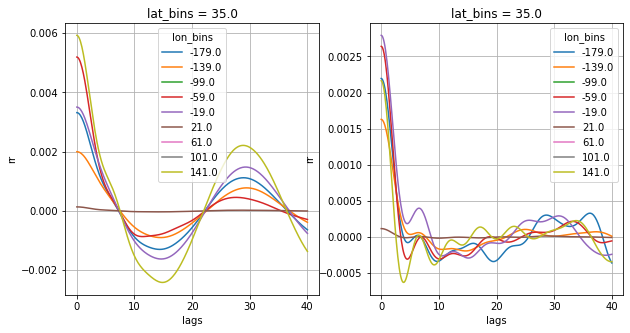

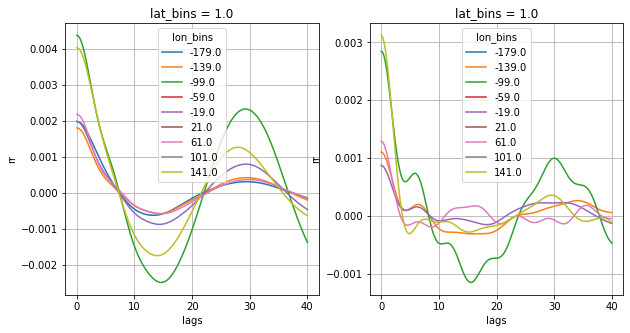

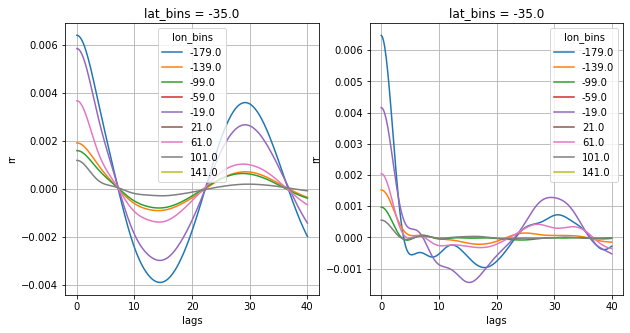

In [17]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=-35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=-35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()

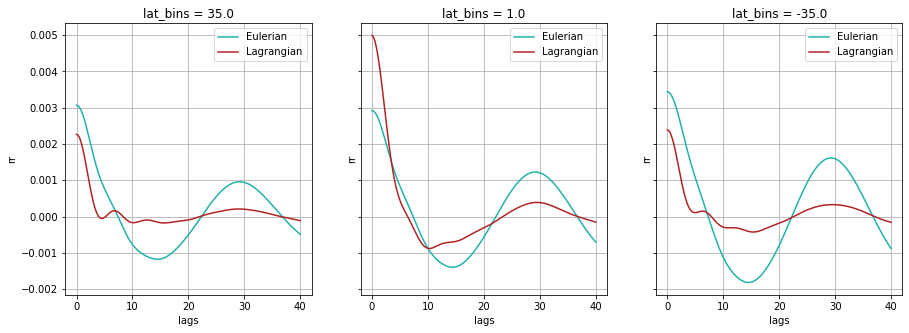

In [24]:
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
dsE.sel(lat_bins=35,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=35,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='firebrick',label='Lagrangian')
axs[0].grid();axs[0].legend()
dsE.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='firebrick',label='Lagrangian')
axs[1].grid();axs[1].legend()
dsE.sel(lat_bins=-35,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=-35,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='firebrick',label='Lagrangian')
axs[2].grid();axs[2].legend()

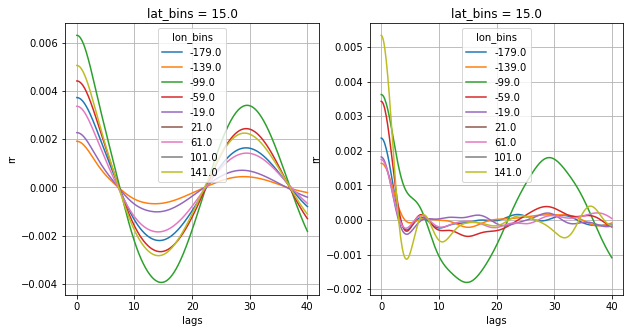

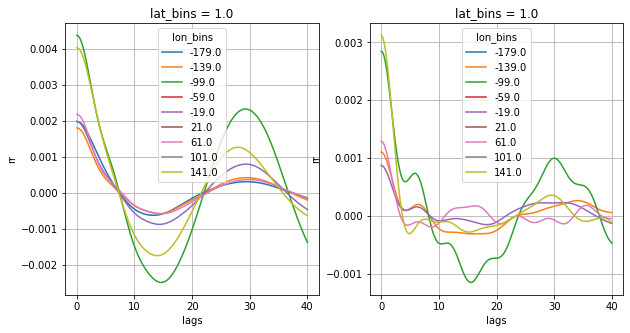

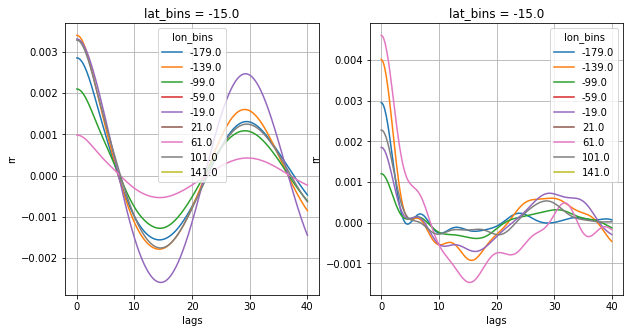

In [25]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=-15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=-15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()

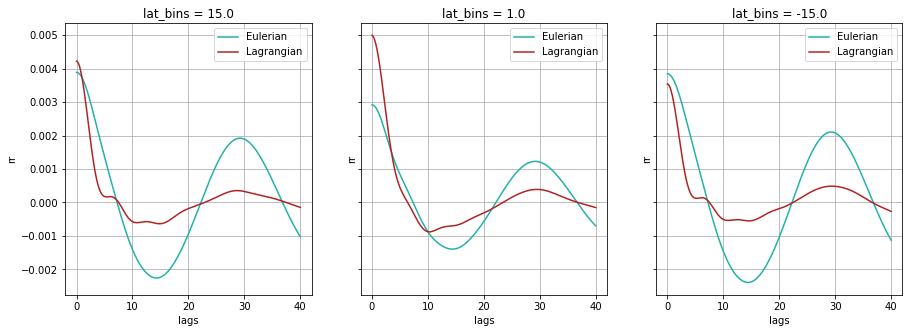

In [26]:
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
dsE.sel(lat_bins=15,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=15,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='firebrick',label='Lagrangian')
axs[0].grid();axs[0].legend()
dsE.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='firebrick',label='Lagrangian')
axs[1].grid();axs[1].legend()
dsE.sel(lat_bins=-15,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=-15,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='firebrick',label='Lagrangian')
axs[2].grid();axs[2].legend()